In [1]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

import numpy as np
import pandas as pd

In [2]:
def fit_image(image: np.array, palette: np.array):
    """Ограничит цвета картинки image наиболее похожими из тех N цветов,
что переданы как palette[1 x N x 3].
Returns:
    fitted_image: np.array[1xNx3],
    color_counts: dict
    """
    from sklearn.metrics import euclidean_distances
    
    indexes = [] # накапливаем метки каждому пикселю -- индексы из "массива" палитры
    for line in image: # приходится полинейно и потом склеивать, т.к. не знаю способа сделать сразу на весь трехмерный набор
        # получим массив расстояний до каждого из цветов палитры и сразу ищем индекс наименьшего расстояния -- и есть метка
        l = euclidean_distances(line, palette[0]).argmin(axis=1) 
        indexes.append(l)


    outs = [] # накапливаем результирующие строки, состоящие из пикселей палитры
    for line in indexes:
        # для каждой строки с индексами, заменяем индекс на значение по индексу из палитры
        paletted_line = list(map(lambda palette_index: palette[0, palette_index], line)) 
        outs.append(paletted_line)
    
    idx, cnt = np.unique(np.array(indexes), return_counts=True)
    counts = dict(zip(idx.tolist(), cnt.tolist()))
    
    return np.array(outs), counts

In [30]:
imgpath = "photo_2021-10-25_18-01-44_pst.jpg"
# imgpath = "posterized7.gif"
# samplepath = "samples.jpg"
samplepath = "palette17.bmp"

In [31]:
img = mpimg.imread(imgpath)
smp = mpimg.imread(samplepath)

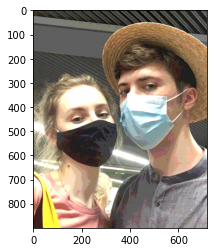

In [32]:
# показать исходник
imshow(img)

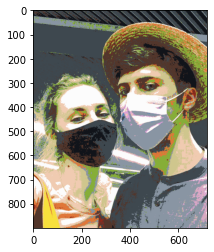

In [33]:
# результат
img_paletted, colors = fit_image(img, smp)
imshow(img_paletted)

In [35]:
colors

{0: 77147,
 1: 25922,
 2: 55463,
 3: 275,
 4: 7835,
 7: 54123,
 8: 52869,
 9: 6304,
 10: 6781,
 13: 40012,
 14: 54931,
 15: 96844,
 16: 169494}

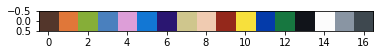

In [36]:
# показать палитру
imshow(smp)

In [37]:
from PIL import Image
im = Image.fromarray(img_paletted)
im.save('photo_palette17_pst.gif')

In [10]:
# %%time

# подбор самых частых K цветов
# K_COLORS = 10

def most_freq_colors(image, colors_count=10, n_estimators=1):
    from sklearn.cluster import KMeans

    topcols = []

    for _ in range(n_estimators): # посмотрим на 3 разных вариаций
        model = KMeans(n_clusters=colors_count) # алгоритм кластеризации KMeans    
        model.fit(img.reshape(-1, img.shape[-1])) # не важна структура-матрица, требуется вектор из RGB

        top_colors = model.cluster_centers_.astype('uint8') # отсекаем к целым, чтобы можно было представить как цвет
        topcol_img = top_colors.reshape(1, -1, 3) # матричный вид, полоска пикселей 1х10х3

        sorted_topcol = np.array(sorted(topcol_img[0], key=lambda rgb: rgb.mean()))

        topcols.append(sorted_topcol)

    topcols = np.array(topcols)
    
    if n_estimators > 1:
        t_means = topcols.T.mean(-1).T.astype('uint8').reshape(1, -1, 3)
        return t_means
    return topcols
    
# imshow(topcols)

Wall time: 550 ms


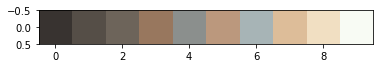

In [11]:
%%time
topcol_mean_palette = most_freq_colors(img)
imshow(topcol_mean_palette)

{0: 2284, 1: 2817, 2: 3181, 3: 2577, 4: 1681, 5: 1596, 6: 908, 7: 1699, 8: 1281, 9: 1576}


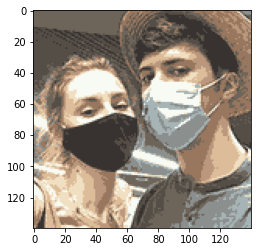

In [12]:
new_image, colors = fit_image(img, topcol_mean_palette)
print(colors)
imshow(new_image)

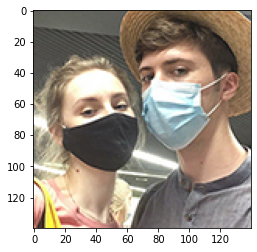

In [13]:
# исходник для сравнения
imshow(img)

In [14]:
from PIL import Image
im = Image.fromarray(new_image)
im.save('photo_trimmed_bestpal.gif')